<h2><center>Programa Nanodegree Engenheiro de Machine Learning</center></h2>
<h3><center>Relatório do projeto de conclusão de machine learning - Capstone</center></h3>
<br>
<center>  
Robson Azevedo Rung<br>
    <i>05/08/2019</i>
</center> 

## I - Definição

### Visão geral do projeto

Esse projeto busca desenvolver uma solução baseada em técnicas de machine learning para prever preços de imóveis.

Imóveis são bens de grande relevância para qualquer sociedade, e têm seus preços formados não de forma única, mas a partir das características que possuem. [A]

Assim sendo, os consumidores potenciais têm a percepção de diferenciaras diversas possibilidades de características em função do que é tido como prioritário. Desta maneira, um determinado consumidor pode escolher seu "pacote" de características disponíveis para cada bem ou serviço em função da percepção de utilidade.

Muitos estudos buscam determinar os atributos intrínsecos e extrínsecos pertencentes a cada residência, a fim de verificar quais deles apresentam maior representatividade para a composição dos instrumentos de demanda e oferta, utilizando-se modelos de preços hedônicos, por meio dos quais é possível analisar a importância relativa de cada atributo em função dos diferentes perfis sociodemográficos. [B]

Uma das atividades de empresas e profissionais do ramo imobiliário é a analisar o valor de imóveis, com objetivo de vendê-los em tempo razoável e maximizar seus lucros.

O conjunto de dados deste trabalho será aquele disponibilizado na competição intitulada *"House Prices: Advanced Regression Techniques"* da plataforma Kaggle. [C]

Constam dos dados diversos atributos, por exemplo:

- Tipo da propriedade;
- Tamanho do lote;
- Recursos públicos disponíveis (eletricidade, gás, água e saneamento);
- Condições de acesso;
- Acabamento (materiais);
- Estado de conservação;
- Tipo da fundação;
- Tipo de aquecimento;
- Sistema elétrico;
- Características da garagem;
- Idade do imóvel;
- etc.

Os dados são fornecidos em dois grupos, um de treinamento e outro de teste (esse não contém o preço de venda, e deve ser usada para envio à competição).

### Declaração do problema

Entender quais características são as mais relevantes e como impactam os preços é tarefa complexa por si só. Além disso, tais fatores podem mudar ao longo do tempo e variam entre regiões geográficas. Podem, ainda, ser afetadas por diferenças culturais e climáticas.

Inicialmente serão usadas técnicas de análise de dados para buscar obter uma compreensão dos tipos de atributos existentes na base de dados, considerando seus tipos de dados e suas possíveis correlações. 

Como auxílio à análise, estatísticas como média, mediana, desvio padrão, valores máximos e mínimos serão calculadas.

Os atributos que precisarem de tratamento especial, como a aplicação de normalização ou *one-hot enconde* serão devidamente tratados.

Buscar-se-á, também, a aplicação da técnica de seleção de atributos (*feature selection*) conhecida como PCA (*Principal Component Analysis*), de modo a evitar-se o problema da dimensionalidade (*curse of dimensionality*).

Será conduzida uma uma busca por *outliers* e dados faltantes, de modo a evitar distorções nos modelos durante o treinamento.

Agora será realizado o treinamento dos modelos. Para o caso da aprendizagem supervisionada, será conduzida uma otimização dos hiperparâmetros usando a técnica de *grid search*, validação com *cross-validation* e regularizção (*regularization*).
    
Agora será realizado o treinamento dos modelos. Para o caso da aprendizagem supervisionada, será conduzida uma otimização dos hiperparâmetros usando a técnica de *grid search*.

Além disso, a mesma tarefa será realizada usando técnicas de deep learning. Será criada e treinada uma rede neural com os dados fornecidos.

For fim, o coeficiente de determinação será calculado para avaliar a performance dos modelos.

### Métricas

Para avaliar a performance dos modelos, será calculado o coeficiente de determinação (R2), um modelo bastante usado para analisar regressões.

O valor de R2 indica o percentual de correlação quadrática entre os valores previstos e os valores reais. Quando o resultado é igual a 0, o modelo de regressão se equivale a um modelo que sempre tem como resultado a média amostral (dados de treinamento). Por outro lado, quando R2 é igual a 1, significa que o modelo foi capaz de prever com precisão os valores da variável alvo.

É possível que R2 tenha como resultado um valor negativo, o que significa que o modelo de regressão é pior do que um modelo que sempre prevê a média.

A competição no Kaggle utiliza-se, para comparar as soluções que são submetidas, a métrica Root Mean Squared Logarithmic Error - RMSLE. Essa métrica calcula a raiz quadrada da média do quadrado das diferenças entre o valor original e o valor previsto. O uso de logs tem como objetivo evitar que erros nos valores previstos de imóveis caros afete mais o resultado do que erros em imóveis baratos. Essa métrica também será calculada neste projeto.

Além disso, com o objetivo de comparação entre as soluções propostas e uma métrica inicial, do tipo ingênua (*naive*), serão calculadas as métricas acima para um conjunto de dados que tenha como preços estimados exatamente a média dos preços de venda existentes. O mesmo procedimento será feito para a mediana.

## II - Análise

### Exploração dos Dados

#### Importação das bibliotecas usadas no projeto

In [1]:
import locale, datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing, metrics, svm
from sklearn.linear_model import ElasticNet, LassoCV, LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA

from scipy import stats
from scipy.stats import skew, norm

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

import xgboost
from xgboost.sklearn import XGBClassifier

Using TensorFlow backend.


#### Funções de apoio

In [122]:
min_max_scaler = preprocessing.MinMaxScaler()

# Função para cálculo da média quadrática entre o logaritmo do valor previsto e o logaritmo do valor estimado.
def rmsle(y, y_pred):
    soma = 0.0
    for i,pred in enumerate(y_pred):
        if (pred > 0) & (y[i] > 0):
            soma += (np.log(pred + 1) - np.log(y[i] + 1)) ** 2.0
        elif pred <= 0:  
            print("Erro na linha {}. Valor previsto menor ou igual a zero: {}.".format(i, pred))
        elif y[i] <= 0:  
            print("Erro na linha {}. Valor original menor ou igual a zero: {}.".format(i, y[i]))
    return float((soma * (1.0/len(y))) ** 0.5)

def mostra_score(_Y_previsto, _Y_correto,titulo=None):
    v_rmsle = rmsle(_Y_correto, _Y_previsto)
    v_r2_score = r2_score(_Y_correto, _Y_previsto)
    if titulo != None:
        print("Resultados para o modelo {}:".format(titulo))
        print("---------------------------------------------------")
    print("R2 Score: {:10.3f}".format(v_r2_score))
    print("RMSLE:    {:10.3f}".format(v_rmsle),end = "\r\n\r\n")
    
def ajusta_valores_previsto(_Y_previsto, _Y_train): 
    df_Y_previsto = pd.DataFrame(_Y_previsto)
    df_Y_previsto.columns = ["previsto"]
    df_Y_previsto[df_Y_previsto["previsto"] <= 0] = np.mean(_Y_train)
    return df_Y_previsto
    
def regressao(model, _X_train, _Y_train, _X_test, _Y_test, titulo=None):
    reg = model.fit(_X_train, _Y_train)

    df_Y_predicted = ajusta_valores_previsto(reg.predict(_X_test), _Y_train)

    mostra_score(_Y_test.values, df_Y_predicted.round(0).values,titulo)
    
def prepara_X_Y_train(_X, _Y, filtro=None, test_size=0.3, random_state = 0):
    if filtro != None:
        X_dados = _X[filtro]
    elif "SalePrice" in _X.columns:
        X_dados = _X.drop("SalePrice", axis=1)
    else:
        X_dados = _X

    # Normalização dos dados com o uso da função min_max_scaler, a qual deixa os dados numa faixa entre 0 e 1
    X_scale = min_max_scaler.fit_transform(X_dados)
    
    # Divisão entre conjunto de treinamento e testes
    # Usaremos a função train_test_split para dividir o conjunto de dados de treinamento entre 2:
    # 70% para treinamento;
    # 30% para testes.
    
    return train_test_split(X_scale, _Y, test_size=test_size, random_state=random_state)
    
def executa_regressoes():
    regressao(LinearRegression(), X_train, Y_train, X_test, Y_test, titulo="Regressão Linear")
    regressao(Ridge(), X_train, Y_train.values, X_test, Y_test, titulo="Ridge")
    regressao(Lasso(), X_train, Y_train.values, X_test, Y_test, titulo="Lasso")
    regressao(ElasticNet(), X_train, Y_train.values, X_test, Y_test, titulo="ElasticNet")
    regressao(DecisionTreeClassifier(), X_train, Y_train.values, X_test, Y_test, titulo="DecisionTreeClassifier")
    regressao(xgboost.XGBRegressor(), X_train, Y_train.values, X_test, Y_test, titulo="XGBoost")


def cria_rede_neural(learn_rate=0.001, quantidade_entrada=150, 
                     activation='relu', camadas=2, neuronios=30,
                     init_mode='uniform',optimizer='SGD'):
    model = Sequential()
    model.reset_states
    model.add(Dense(quantidade_entrada, kernel_initializer=init_mode, activation=activation, input_dim=quantidade_entrada))
    for i in range(camadas):
        model.add(Dense(neuronios, kernel_initializer=init_mode, activation=activation))
    model.add(Dense(1, kernel_initializer=init_mode))
    
    if optimizer == 'adam':
        opt = optimizers.adam(lr=learn_rate)
        model.compile(loss='mean_squared_logarithmic_error', optimizer=opt)
    elif optimizer == 'SGD':
        opt = optimizers.SGD(lr=learn_rate)
        model.compile(loss='mean_squared_logarithmic_error', optimizer=opt)        
    else:
        model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer)
    
    return model

def treina_rede_neural(model, X_train, Y_train, X_test, Y_test, epochs=100, batch_size=30, 
                       mostra_execucao=True):
    if mostra_execucao:
        print(datetime.datetime.now())

        hist = model.fit(X_train, Y_train,
                  batch_size=batch_size, epochs=epochs, verbose=1,
                  validation_data=(X_test, Y_test))

        print(datetime.datetime.now())
    else:
        hist = model.fit(X_train, Y_train,
                  batch_size=batch_size, epochs=epochs, verbose=0,
                  validation_data=(X_test, Y_test))

    model.evaluate(X_test, Y_test)

def executa_rede_neural(model, X_test, Y_train):
    Y_predicted = model.predict(X_test)

    df_Y_predicted = ajusta_valores_previsto(Y_predicted.tolist(), Y_train)

    mostra_score(Y_test.values, df_Y_predicted.round(0).values, "Rede Neural")

#### Descrição resumida dos dados (transcrição do original, sem tradução)

````
MSSubClass: Identifies the type of dwelling involved in the sale.	
MSZoning: Identifies the general zoning classification of the sale.
LotFrontage: Linear feet of street connected to property
LotArea: Lot size in square feet
Street: Type of road access to property
Alley: Type of alley access to property
LotShape: General shape of property
LandContour: Flatness of the property
Utilities: Type of utilities available
LotConfig: Lot configuration
LandSlope: Slope of property
Neighborhood: Physical locations within Ames city limits
Condition1: Proximity to various conditions
Condition2: Proximity to various conditions (if more than one is present)
BldgType: Type of dwelling
HouseStyle: Style of dwelling
OverallQual: Rates the overall material and finish of the house
OverallCond: Rates the overall condition of the house
YearBuilt: Original construction date
YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
RoofStyle: Type of roof
RoofMatl: Roof material
Exterior1st: Exterior covering on house
Exterior2nd: Exterior covering on house (if more than one material)
MasVnrType: Masonry veneer type
MasVnrArea: Masonry veneer area in square feet
ExterQual: Evaluates the quality of the material on the exterior 
ExterCond: Evaluates the present condition of the material on the exterior
Foundation: Type of foundation
BsmtQual: Evaluates the height of the basement
BsmtCond: Evaluates the general condition of the basement
BsmtExposure: Refers to walkout or garden level walls
BsmtFinType1: Rating of basement finished area
BsmtFinSF1: Type 1 finished square feet
BsmtFinType2: Rating of basement finished area (if multiple types)
BsmtFinSF2: Type 2 finished square feet
BsmtUnfSF: Unfinished square feet of basement area
TotalBsmtSF: Total square feet of basement area
Heating: Type of heating
HeatingQC: Heating quality and condition
CentralAir: Central air conditioning
Electrical: Electrical system
1stFlrSF: First Floor square feet
2ndFlrSF: Second floor square feet
LowQualFinSF: Low quality finished square feet (all floors)
GrLivArea: Above grade (ground) living area square feet
BsmtFullBath: Basement full bathrooms
BsmtHalfBath: Basement half bathrooms
FullBath: Full bathrooms above grade
HalfBath: Half baths above grade
Bedroom: Bedrooms above grade (does NOT include basement bedrooms)
Kitchen: Kitchens above grade
KitchenQual: Kitchen quality
TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
Functional: Home functionality (Assume typical unless deductions are warranted)
Fireplaces: Number of fireplaces
FireplaceQu: Fireplace quality
GarageType: Garage location
GarageYrBlt: Year garage was built
GarageFinish: Interior finish of the garage
GarageCars: Size of garage in car capacity
GarageArea: Size of garage in square feet
GarageQual: Garage quality
GarageCond: Garage condition
PavedDrive: Paved driveway
WoodDeckSF: Wood deck area in square feet
OpenPorchSF: Open porch area in square feet
EnclosedPorch: Enclosed porch area in square feet
3SsnPorch: Three season porch area in square feet
ScreenPorch: Screen porch area in square feet
PoolArea: Pool area in square feet
PoolQC: Pool quality
Fence: Fence quality
MiscFeature: Miscellaneous feature not covered in other categories
MiscVal: $Value of miscellaneous feature
MoSold: Month Sold (MM)
YrSold: Year Sold (YYYY)
SaleType: Type of sale
SaleCondition: Condition of sale
````

[Descrição completa dos dados](data_description.txt)

#### Carregamento da Base de Dados

Usando a biblioteca Pandas, vamos carregar o arquivo *csv* contendo os dados de treinamento.

In [3]:
train = pd.read_csv("train.csv")

print("A base de dados possui {} linhas e {} colunas, sendo uma delas o preço de venda.".format(train.shape[0],train.shape[1]))

print("")

atributos_numericos = train.select_dtypes(exclude = ["object"]).columns
atributos_categoricos = train.select_dtypes(include = ["object"]).columns
print("Dos {} atributos, {} são categóricos e {} são numéricos.".format(train.shape[1] - 1, len(atributos_categoricos), len(atributos_numericos) - 1))

A base de dados possui 1460 linhas e 81 colunas, sendo uma delas o preço de venda.

Dos 80 atributos, 43 são categóricos e 37 são numéricos.


*Atributos numéricos*

In [4]:
atributos_numericos

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

*Atributos categóricos*

In [5]:
atributos_categoricos

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

*10 primeiras linhas*

In [6]:
train.head(n=10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


#### Estatísticas

Vamos visualizar as principais estatísticas dos atributos da base, com objetivo de irmos, aos poucos, ganhando intuição sobre os dados.

In [7]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Estatísticas sobre o preço de venda:

In [8]:
locale.setlocale(locale.LC_ALL, 'en_US.utf-8') 

Y_train_full = pd.DataFrame(train["SalePrice"])
X_train_full = train.drop(["SalePrice"], axis=1)
Y_train_full.index = X_train_full.index

print("Valor mínimo do conjunto de treinamento ------>  {}".format(locale.currency(Y_train_full["SalePrice"].min(), grouping=True)))
print("Valor máximo do conjunto de treinamento ------> {}".format(locale.currency(Y_train_full["SalePrice"].max(), grouping=True)))
print("Valor da média do conjunto de treinamento ----> {}".format(locale.currency(Y_train_full["SalePrice"].mean(), grouping=True)))
print("Valor da mediana do conjunto de treinamento --> {}".format(locale.currency(Y_train_full["SalePrice"].median(), grouping=True)))
print("Valor do desvio padrão ----------------------->  {}".format(locale.currency(Y_train_full["SalePrice"].std(), grouping=True)))

Valor mínimo do conjunto de treinamento ------>  $34,900.00
Valor máximo do conjunto de treinamento ------> $755,000.00
Valor da média do conjunto de treinamento ----> $180,921.20
Valor da mediana do conjunto de treinamento --> $163,000.00
Valor do desvio padrão ----------------------->  $79,442.50


#### Dados nulos 

Abaixo são listados os atributos com valores nulos e a quantidade de registros nessas condições. Futuramente os ajustes necessáriso serão realizados.

In [9]:
train_null = train.isnull().sum()
train_null = train_null[train_null>0]
train_null.sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

#### Correlação

Visualizaremos agora os atributos que apresetam graus de correlação acima de 50% com o preço de venda.

In [10]:
corrmat = train.corr()

atributos_correlacao_preco_maior_50 = []
for id in corrmat.index:
    achouDiagonal = False
    if (id != "SalePrice") & (corrmat.loc[id]["SalePrice"] > 0.5):
        atributos_correlacao_preco_maior_50.append(id)
        print("Correlação de {:12s} com SalePrice: {:1.3f}".format(id, corrmat.loc[id]["SalePrice"]))

Correlação de OverallQual  com SalePrice: 0.791
Correlação de YearBuilt    com SalePrice: 0.523
Correlação de YearRemodAdd com SalePrice: 0.507
Correlação de TotalBsmtSF  com SalePrice: 0.614
Correlação de 1stFlrSF     com SalePrice: 0.606
Correlação de GrLivArea    com SalePrice: 0.709
Correlação de FullBath     com SalePrice: 0.561
Correlação de TotRmsAbvGrd com SalePrice: 0.534
Correlação de GarageCars   com SalePrice: 0.640
Correlação de GarageArea   com SalePrice: 0.623


#### *Outliers*

Analisaremos agora a existência de outliers para os atributos selecionados acima (correlação acima de 50% com o preço de venda). Posteriormente eles serão devidamente tratados.

In [11]:
filtro = list(atributos_correlacao_preco_maior_50)
filtro.append("SalePrice")

outliers = pd.DataFrame()

for col in filtro:
    z = np.abs(stats.zscore(train[col]))
    outliers = pd.concat([outliers, train.iloc[np.where(z > 3)[0]]])

print("Foram encontrados {} outliers.".format(outliers.shape[0]))

Foram encontrados 87 outliers.


### Visualização exploratória

#### Distribição do preço de venda

Text(0.5, 1.0, 'Distribuição do atributo SalePrice')

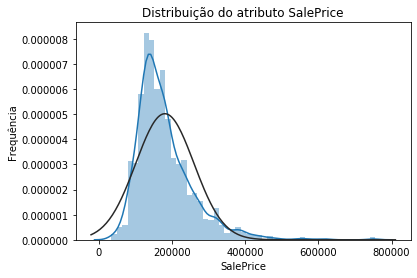

In [12]:
sns.distplot(train['SalePrice'] , fit=norm);

plt.ylabel('Frequência')
plt.title('Distribuição do atributo SalePrice')


Percebe-se que os preços seguem uma distribuição normal com assimetria à direta, o que será ajustado posteriormente.

#### Correlação

Iniciaremos com uma visualização da matriz de correlação.

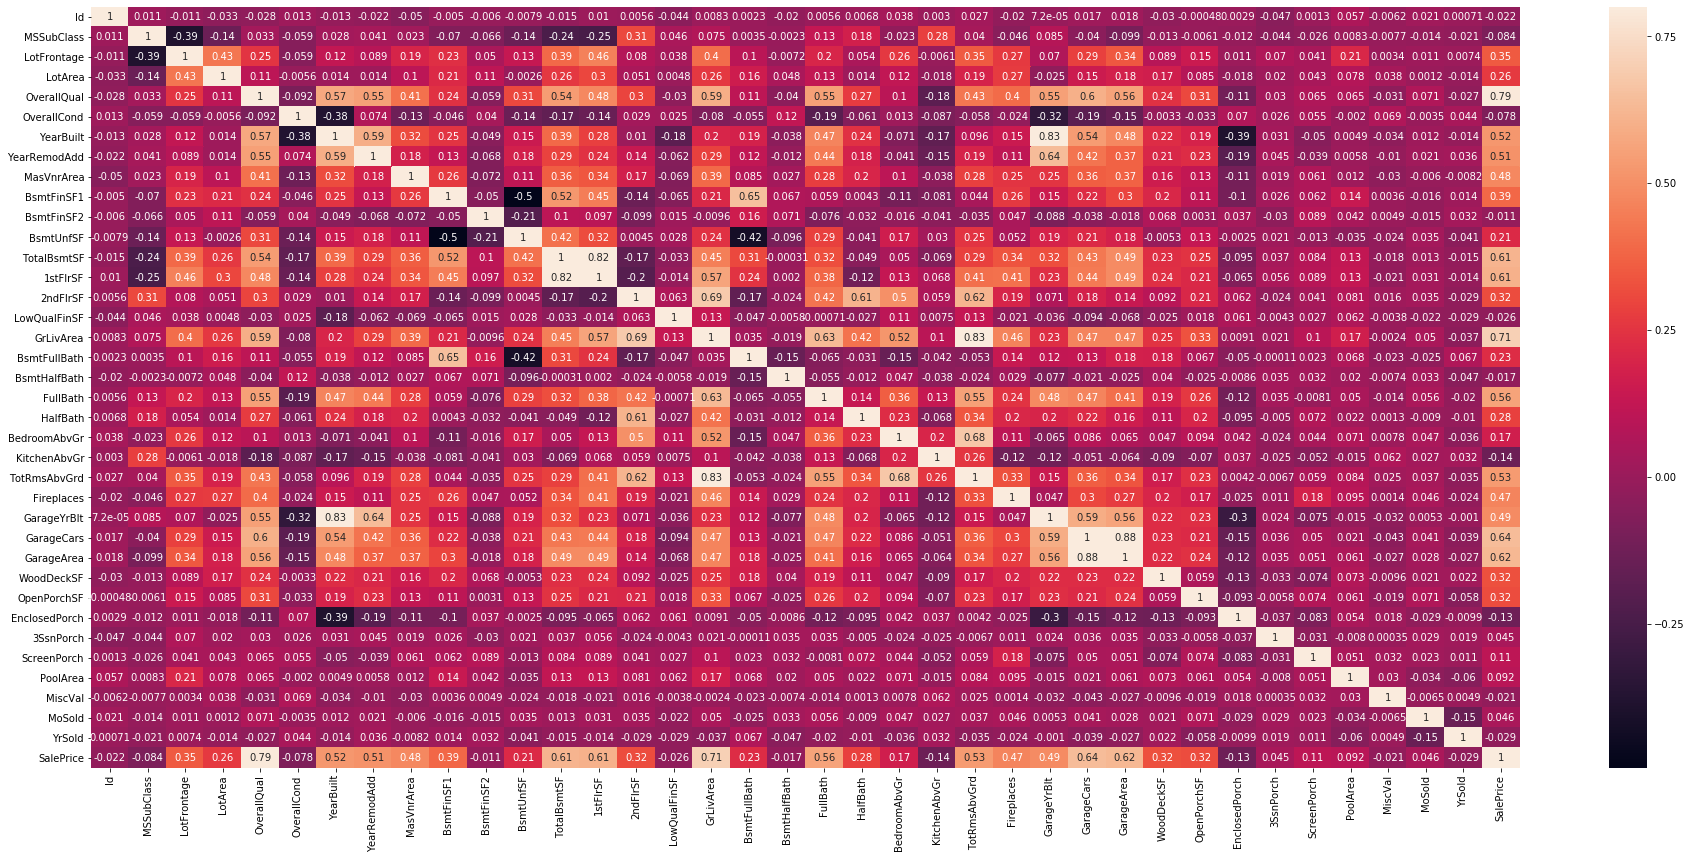

In [13]:
f, ax = plt.subplots(figsize=(32, 14))
sns.heatmap(corrmat, vmax=.8, annot=True);

##### Visualização da correlação dos principais atributos com o preço de venda

Para os atributos com correlação maior de que 50% com o preço da venda, visualizaremos sua correlação com o preço de venda. 

Essa informação será útil posteriormente quando tratarmos os *outliers*.

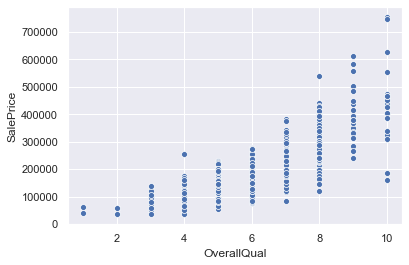

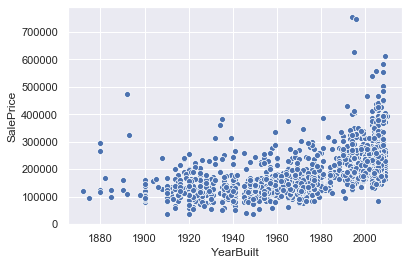

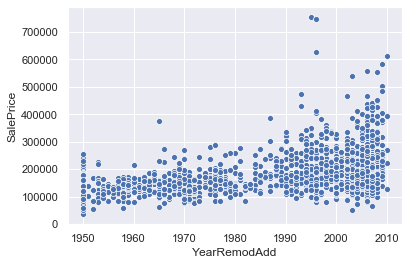

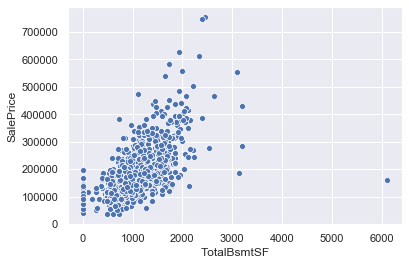

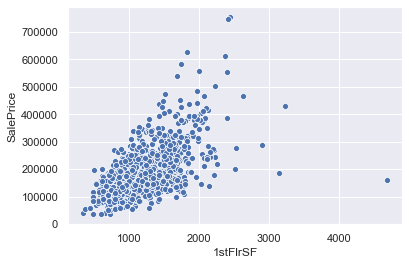

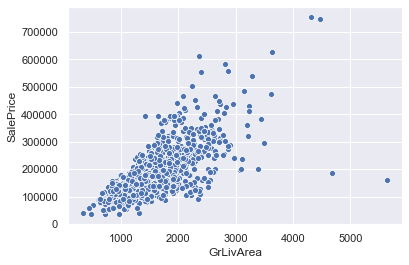

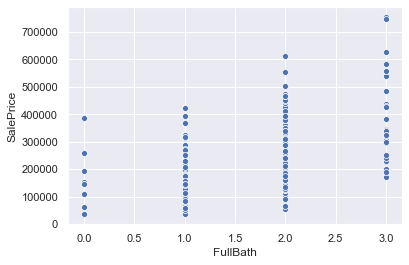

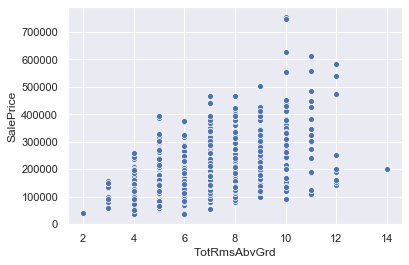

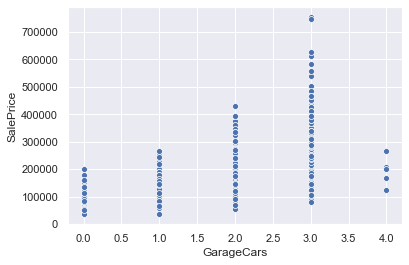

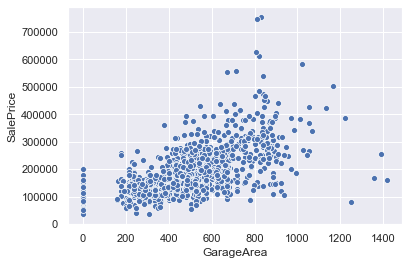

In [14]:
sns.set()
for attr in atributos_correlacao_preco_maior_50:
    sns.scatterplot(train[attr],train.SalePrice)
    plt.show()

#### Visualização em barras dos 3 atributos com os maiores graus de correlação com o preço de venda.

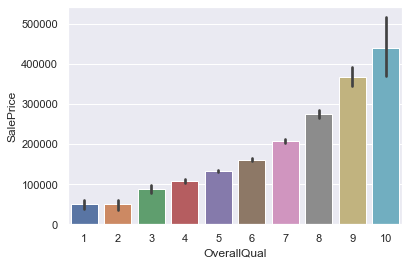

In [15]:
sns.barplot(train["OverallQual"],train.SalePrice)

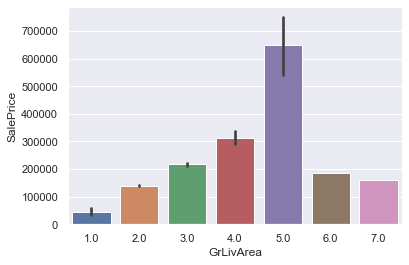

In [16]:
sns.barplot(round(train["GrLivArea"] / 1000 + 1),train.SalePrice)

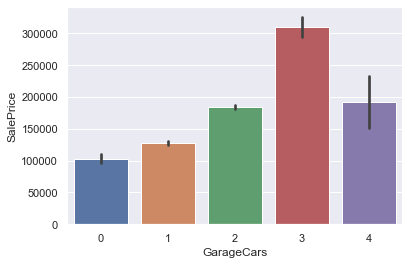

In [17]:
sns.barplot(train["GarageCars"],train.SalePrice)

Fica claro acima que a qualidade geral do imóvel tem uma inflência direta e linear no preço. Além disso, imóveis com salas de estar com área em torno de 5.000 pés quadrados e 3 vagas de garagem são os mais valorizados.

### Algoritmos e técnicas

A estimativa dos valores de venda de um imóvel é um problema estatístico de regressão. Uma regressão busca encontrar valores que não estão disponíveis inicialmente. Para isso, baseia-se em dados existentes para aprender as relações entre as variáveis.

Em *machine learning*, o aprendizado supervisionado (*supervised learning*) consiste de técnicas que buscam encontar a ligação entre atributos de entrada de várias observações e um valor, também da observação, que depende desses atributos.

Matematicamente, podemos dizer os atributos das observações formam um matriz $X$, com dimensões $m$ x $n$ (sendo $m$ a quantidade de observações e $n$ a quantidade de atributos), e os valores dependentes formam um vetor $Y$, com dimensão $m$. 

Existem basicamente dois tipos de algoritmos preditivos: classificação e regressão. O primeiro busca classificar os dados de entrada em grupos. O segundo tem como objetivo encontrar um valor para os dados de entrada. Como exemplo, classificar e-mails como *spam* ou não é uma tarefa de classificação. Por outro lado, conforme já comentado anteriormente, prever preços de imóveis é um problema de regressão.

A regressão linear é uma classe de algoritmos de regressão capazes de receber um conjunto de observações como entrada (contendo os atributos e os valores dependentes desses atributos) e ser treinado para encontrar uma equação linear que possa estimar os valores dependentes para novas observação contendo apenas os atributos.

Sendo assim, esse tipo de regressão é aplicável ao problema sendo tratado neste projeto. Como existem vários algoritmos para realização de regressões lineares, ao longo da análise vamos buscar encontrar qual deles funciona melhor para nosso conjunto de dados e, posteriormente, vamos otimizá-lo.

Os algoritmos que testaremos, os quais estão disponíveis na biblioteca *scikit learn*, são:

*Linear Regression* 

Implementação da regressão linear dos mínimos quadrados ordinários. A lógica de funcionamento é tentar minimizar o somatório dos quadrados das diferenças entre os valores originais e estimados.

*Ridge Regression* 

Esse algoritmo resolve alguns dos problemas dos mínimos quadrados ordinários, aplicando uma penalidade ao tamanho dos coeficientes.

*Lasso* 

É um modelo linear que estima coeficientes esparsos, o que é útil em alguns contextos devido a sua tendência de priorizar soluções com poucos coeficientes diferentes de zero, diminuindo a quantidade de atributos dos quais a solução depende.

*ElasticNet* 

É modelo de regressão linear que usa regularização L1 e L2 dos coeficientes, sendo útil em bases esparsas. É útil quando existem vários recursos correlacionados entre si. 

*Bayesian Regression* 

Impõe parâmetros de regularização não fixos durante processo de estimação. Tais parâmetros são otimizados para os dados utilizados, fazendo com que se adapte aos dados.

Testaremos também dois modelos baseados em árvores de decisão: 

*Decision Trees*
Trata-se de um modelo não paramétrico usado tanto para classificação quanto para regressão. O algoritmo consiste em construir uma árvore de decisão que seja capaz de estimar o valor desejado com base nas atributos de entrada.

*XGBoost (eXtreme Gradient Boosting)*
É uma implementação de *gradient boosted decision trees* focada em performance (do próprio modelo) e em velocidade computacional.
Algumas características são:
- Habilidade de lidar com valores faltantes;
- Paralelismo;
- Possibilidade continuar a treinar um modelo já treinado usando outros dados.

Para que os algoritmos passam ser usados da melhor forma possível, precisaremos aplicar algumas técnicas de pré-processamento para ajustar os dados, com base no que já verificamos acima:
- Os dados nulos precisam ser ajustados;
- Os dados categóricos precisam ser convertidos usando a técnica *one-hot encode*;
- A assimetria identificada precisa ser ajustada. Usamos a aplicação da função de *log* para esse fim;
- Os dados numéricos precisam ser normalizados para afetarem de forma igual o processo de treinamento.

Usaremos, também, a técnica conhecida como PCA (*Principal Component Analysis*) para evitar o problema da dimensionalidade. Tal técnica busca formar componentes que representem de forma agregada a variância dos dados, o que nos dá, também, o efeito de selecionar atributos.

Para realizarmos as primeiras regressões que servirão como benchmark para as demais, será usada a correlação dos atributos com o preço do imóvel, de modo a serem usados apenas os com maior grau de correlação.

Quando os dados estiverem totalmente trabalhados, vamos otimizar o algoritmo que estiver com a melhor performance, usando a técnica de Grid Search, a qual é capaz de receber uma lista de parâmetros aceitos pelo modelo, cada um acompanhado de um conjunto de valores que se deseja testar. Com base nisso, são executadas simulações do modelo com todas as possíveis combinações dos valores dos parâmetros. Por exemplo, se o modelo aceitar dois parâmetros númericos A e B, e informamos que queremos testar os valores 1 e 2 para A, e 10 e 30 para B, o modelo será executado com as 4 possíveis combinações: A = 1 e B = 10; A = 1 e B = 30; A = 2 e B = 10; A = 2 e B = 30. Ao final pode-se verificar qual combinação obteve o melhor resultado.

Outra técnica que será usada como alternativa para solucionar o problema de prever os preços é a aplicação de redes neurais como ferramenta de regressão.

Redes neurais simulam o modo de funcionamento do cérebro humano. São formadas por camadas estruturadas constituídas por unidades de processamento. Pesos são atribuídos a cada uma dessas unidades e vão sendo ajustados durante o treinamento, a fim de atingir o objetivo pretendido, que é a capacidade de fornecer um resultado com base nas entradas. Os dados de entrada e o que se busca como saída dependem do problema que está se buscando resolver. No nosso caso, a entrada será formanda pelos atributos dos imóveis e a saída será a estimativa do preço de venda.

### Benchmark

Uma boa prática quando se busca treinar modelos de aprendizagem supervisionada é calcular, como benchmark inicial, o índice de performance escolhido com base em uma previsão ingênua. Usaremos o valor da média e da mediana. Ou seja, criaremos um vetor de resultado totalmente preenchido com o valor da média e, depois, outro com o valor da mediana.

Conforme comentado anteriormente, usaremos duas métricas: R2 e RMSLE.

Evoluiremos o bechmark inicial com as métricas calculadas com base em previsões que usarão apenas os atributos mais correlacionados com o preço de venda, sem realizar otimizações.

## III - Metodologia

### Pré-processamento

*Ajuste dos dados nulos - dados categóricos* 

Começaremos com a atribuição do valor *NA* para os atributos abaixo, indicando que não existe aquela cacterística no imóvel, ou ela não se aplica devido ao fato de ser dependente de outro atributo que não consta da propriedade. Um exemplo disso são os atributos sobre a garagem (condição, tipo, etc.). Se não existir garagem, esses atributos não fazem sentido. Por outro lado, caso exista garagem e esses dados pudessem estar preenchidos, não teríamos como descobrir seus valores, de modo que colocar o valor *NA* faz sentido.

In [18]:
train["PoolQC"].fillna("NA", inplace=True)

train["MiscFeature"].fillna("NA", inplace=True)

train["Alley"].fillna("NA", inplace=True)

train["Fence"].fillna("NA", inplace=True)

train["FireplaceQu"].fillna("NA", inplace=True)

train["GarageCond"].fillna("NA", inplace=True)
train["GarageQual"].fillna("NA", inplace=True)
train["GarageFinish"].fillna("NA", inplace=True)
train["GarageType"].fillna("NA", inplace=True)

train["BsmtFinType2"].fillna("NA", inplace=True)
train["BsmtExposure"].fillna("NA", inplace=True)
train["BsmtFinType1"].fillna("NA", inplace=True)
train["BsmtCond"].fillna("NA", inplace=True)
train["BsmtQual"].fillna("NA", inplace=True)

O atributo *MasVnrType* indica o tipo de alvenaria, e o colocaremos como *None*, quando for nulo.

In [19]:
train["MasVnrType"].fillna("None", inplace=True)

O atributo *Electrical* indica o tipo de ligação elétrica. O tipo mais genérico seria o misturado *Mixed*, de modo que usaremos o valor *Mix* .

In [20]:
train["Electrical"].fillna("Mix", inplace=True)

Os atributos abaixo dizem respeito a medidas numéricas. Nossa opção é atribuirmos o valor zero.

In [21]:
train["LotFrontage"].fillna(0, inplace=True)
train["MasVnrArea"].fillna(0, inplace=True)

O atributos *GarageYrBlt* indica o ano de construção da garagem. Considerando que há o mesmo número de linhas com esse atributo nulo, quando coparado ao número de linhas com os demais atributos da garagem também nulos, provavelmente são imóveis sem garagem, de forma que atribuiremos o valor zero.

In [22]:
train["GarageYrBlt"].fillna(0, inplace=True)

Vamos confirmar se não existem mais atributos nulos.

In [23]:
train_null = train.isnull().sum()
train_null = train_null[train_null>0]
train_null.sort_values(ascending=False)

Series([], dtype: int64)

#### Cálculo das métricas a serem usadas como base

Agora iremos calcular as métricas para um conjunto de dados que tem como valores previstos a média dos valores originais (aqui, conforme dito acima, o resultado será igual a zero). Na sequência, o mesmo procedimento será feito usando a mediana.

In [24]:
Y_media = np.full((len(Y_train_full)), np.mean(Y_train_full))
mostra_score(Y_media, Y_train_full["SalePrice"].array, "Média")

Resultados para o modelo Média:
---------------------------------------------------
R2 Score:      0.000
RMSLE:         0.408



In [25]:
Y_median = np.full((len(Y_train_full)), np.median(Y_train_full))
mostra_score(Y_median, Y_train_full["SalePrice"].array, "Média")

Resultados para o modelo Média:
---------------------------------------------------
R2 Score:     -0.051
RMSLE:         0.400



Com base nos cálculos acima, nosso objetivo será buscar projeções que apresentem, pelo menos, R2 Score maior do que 0.0 e RMSLE menor do que 0.4.

*Criação e exibição de um novo DataFrame apenas com os atributos que possuem correlação maior do que 50% com o preço de venda.*

In [26]:
X_train_full[atributos_correlacao_preco_maior_50].head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea
0,7,2003,2003,856,856,1710,2,8,2,548
1,6,1976,1976,1262,1262,1262,2,6,2,460
2,7,2001,2002,920,920,1786,2,6,2,608
3,7,1915,1970,756,961,1717,1,7,3,642
4,8,2000,2000,1145,1145,2198,2,9,3,836


##### Regressões com atributos que possuem correlação maior do que 50% com o preço de venda

Executaremos agora os modelos com base nos atributos que possuem correlação maior do que 50% com o preço de venda. 

Não será realizado nenhum tipo de otimização.

Os melhores índices alcançados, se melhores do que os obtidos anteriormente com a média e a mediana, serão usados como benchmark para as futuras tentativas de melhorar os resultados.

In [27]:
# Separação dos dados em conjunto de treinamento e teste
X_train, X_test, Y_train, Y_test = prepara_X_Y_train(X_train_full, Y_train_full["SalePrice"],filtro=atributos_correlacao_preco_maior_50)
executa_regressoes()

Resultados para o modelo Regressão Linear:
---------------------------------------------------
R2 Score:      0.660
RMSLE:         0.212

Resultados para o modelo Ridge:
---------------------------------------------------
R2 Score:      0.654
RMSLE:         0.203

Resultados para o modelo Lasso:
---------------------------------------------------
R2 Score:      0.660
RMSLE:         0.212

Resultados para o modelo ElasticNet:
---------------------------------------------------
R2 Score:    -18.297
RMSLE:         0.330

Resultados para o modelo DecisionTreeClassifier:
---------------------------------------------------
R2 Score:      0.706
RMSLE:         0.225

[17:54:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Resultados para o modelo XGBoost:
---------------------------------------------------
R2 Score:      0.842
RMSLE:         0.160



In [28]:
model = cria_rede_neural(10, [10, 32, 16, 32])
treina_rede_neural(model, X_train, Y_train, X_test, Y_test, epochs=100, mostra_execucao=True, lr=0.0001)

Instructions for updating:
Colocations handled automatically by placer.
2019-08-05 17:54:34.302022
Instructions for updating:
Use tf.cast instead.
Train on 1022 samples, validate on 438 samples
Epoch 1/100
1022/1022 [==============================] - 1s 974us/step - loss: 142.0679 - val_loss: 138.1552
Epoch 2/100
1022/1022 [==============================] - 0s 48us/step - loss: 129.0814 - val_loss: 116.1421
Epoch 3/100
1022/1022 [==============================] - 0s 54us/step - loss: 102.0023 - val_loss: 88.2033
Epoch 4/100
1022/1022 [==============================] - 0s 49us/step - loss: 78.4399 - val_loss: 69.6430
Epoch 5/100
1022/1022 [==============================] - 0s 48us/step - loss: 63.3895 - val_loss: 57.6335
Epoch 6/100
1022/1022 [==============================] - 0s 49us/step - loss: 53.2880 - val_loss: 49.2150
Epoch 7/100
1022/1022 [==============================] - 0s 45us/step - loss: 45.9789 - val_loss: 42.9062
Epoch 8/100
1022/1022 [==============================] - 0

1022/1022 [==============================] - 0s 45us/step - loss: 0.4330 - val_loss: 0.4211
Epoch 73/100
1022/1022 [==============================] - 0s 43us/step - loss: 0.4065 - val_loss: 0.3953
Epoch 74/100
1022/1022 [==============================] - 0s 44us/step - loss: 0.3817 - val_loss: 0.3710
Epoch 75/100
1022/1022 [==============================] - 0s 43us/step - loss: 0.3583 - val_loss: 0.3484
Epoch 76/100
1022/1022 [==============================] - 0s 44us/step - loss: 0.3365 - val_loss: 0.3270
Epoch 77/100
1022/1022 [==============================] - 0s 44us/step - loss: 0.3160 - val_loss: 0.3070
Epoch 78/100
1022/1022 [==============================] - 0s 44us/step - loss: 0.2968 - val_loss: 0.2885
Epoch 79/100
1022/1022 [==============================] - 0s 42us/step - loss: 0.2789 - val_loss: 0.2709
Epoch 80/100
1022/1022 [==============================] - 0s 45us/step - loss: 0.2621 - val_loss: 0.2546
Epoch 81/100
1022/1022 [==============================] - 0s 44us/st

In [29]:
executa_rede_neural(model, X_test, Y_train)

Resultados para o modelo Rede Neural:
---------------------------------------------------
R2 Score:     -3.508
RMSLE:         0.294



,previsto
0,173307.921875
1,99995.500000
2,98813.750000
3,155007.328125
4,110281.531250
5,110915.679688
6,186606.984375
7,104881.742188
8,229636.765625
9,150934.703125


Houve uma melhora significativa nos índices. O melhor modelo nessa primeira fase de execução com dados não trabalhados e modelos não otimizados foi o *XGBoost*. Passaremos a usar seus índices como *benchmark*.

#### Continuando o pré-processamento...

##### Remoção de outliers 

Faremos o ajuste de outliers para o preço e para os atributos com correlação maior do que 50% com o preço.

Para definir se um valor deve ser considerado como *outlier*, vamos usar como citério o *z-score*, o qual corresponde ao número de desvios-padrões de distância da média um valor está. Usaremos como limiar o valor 3.

In [30]:
filtro = list(atributos_correlacao_preco_maior_50)

train_sem_outliers = train

for col in filtro:
    z = np.abs(stats.zscore(train_sem_outliers[col]))
    train_sem_outliers = train_sem_outliers.iloc[np.where(z < 3)[0]]
print("Após a remoção de outliers restaram {} linhas de observações.".format(train_sem_outliers.shape[0]))

Após a remoção de outliers restaram 1411 linhas de observações.


Vamos executar as regressões para ver o impacto da remoção dos outliers

In [31]:
X_train, X_test, Y_train, Y_test = prepara_X_Y_train(train_sem_outliers.drop("SalePrice", axis=1), train_sem_outliers["SalePrice"], atributos_correlacao_preco_maior_50)
executa_regressoes()

Resultados para o modelo Regressão Linear:
---------------------------------------------------
R2 Score:      0.783
RMSLE:         0.173

Resultados para o modelo Ridge:
---------------------------------------------------
R2 Score:      0.774
RMSLE:         0.170

Resultados para o modelo Lasso:
---------------------------------------------------
R2 Score:      0.782
RMSLE:         0.173

Resultados para o modelo ElasticNet:
---------------------------------------------------
R2 Score:     -7.861
RMSLE:         0.289

Resultados para o modelo DecisionTreeClassifier:
---------------------------------------------------
R2 Score:      0.657
RMSLE:         0.234

[17:54:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Resultados para o modelo XGBoost:
---------------------------------------------------
R2 Score:      0.838
RMSLE:         0.150



In [32]:
model = cria_rede_neural(10, [10, 32, 16, 32])
treina_rede_neural(model, X_train, Y_train, X_test, Y_test, epochs=100, mostra_execucao=False)

424/424 [==============================] - 0s 14us/step


In [33]:
executa_rede_neural(model, X_test, Y_train)

Resultados para o modelo Rede Neural:
---------------------------------------------------
R2 Score:     -3.494
RMSLE:         0.322



,previsto
0,90739.992188
1,156680.656250
2,148854.281250
3,134913.468750
4,115294.187500
5,95812.914062
6,121404.132812
7,144944.781250
8,183546.000000
9,124726.492188


Já conseguimos uma boa melhoria nos resultados apenas com a remoção dos *outliers*. Estamos no caminho certo, vamos em frente.

##### Separação entre atributos categóricos e numéricos

Vamos agora realizar tratamentos específicos para tipos de dados numéricos e categóricos, de modo que farem a separação em dois conjuntos de dados. Posteriormente iremos juntá-los novamente.

In [34]:
atributos_categoricos = train_sem_outliers.select_dtypes(include=['object']).columns
atributos_categoricos

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [35]:
atributos_numericos = train_sem_outliers.select_dtypes(exclude = ["object"]).columns
atributos_numericos

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [36]:
y_train_sales_price = train_sem_outliers["SalePrice"]
x_train_numerico = train_sem_outliers[atributos_numericos].drop("SalePrice", axis=1)
x_train_categorico = train_sem_outliers[atributos_categoricos]

##### Tratamento das assimetrias 

Vamos ordenar os atributos ordem decrescente de assimetria.

In [37]:
assimetria = x_train_numerico.apply(lambda x: skew(x))
assimetria.sort_values(ascending=False)

MiscVal          29.323497
PoolArea         21.950113
LotArea          12.983405
LowQualFinSF     10.515481
3SsnPorch        10.114813
KitchenAbvGr      4.694928
BsmtFinSF2        4.334053
BsmtHalfBath      4.114670
ScreenPorch       4.043380
EnclosedPorch     2.852881
MasVnrArea        2.611092
OpenPorchSF       2.363140
WoodDeckSF        1.575893
MSSubClass        1.397122
BsmtUnfSF         0.893013
2ndFlrSF          0.735560
OverallCond       0.728665
BsmtFinSF1        0.685005
HalfBath          0.674581
Fireplaces        0.644920
1stFlrSF          0.620179
BsmtFullBath      0.600608
GrLivArea         0.548258
TotRmsAbvGrd      0.439803
MoSold            0.217119
OverallQual       0.202955
TotalBsmtSF       0.145231
YrSold            0.098417
Id                0.004529
LotFrontage      -0.012120
FullBath         -0.035158
BedroomAbvGr     -0.038477
GarageArea       -0.046110
GarageCars       -0.424701
YearRemodAdd     -0.490202
YearBuilt        -0.552156
GarageYrBlt      -3.964243
d

*Visualização do atributo com maior assimetria* 

Text(0.5, 1.0, 'Distribuição do atributo MiscVal')

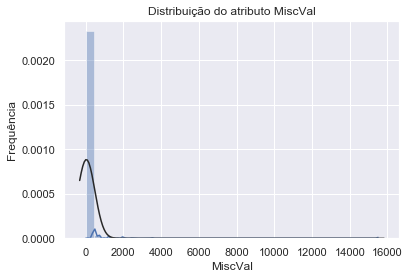

In [38]:
sns.distplot(x_train_numerico['MiscVal'] , fit=norm);

plt.ylabel('Frequência')
plt.title('Distribuição do atributo MiscVal')

*Ajuste de todos os atributos com assimetria maior do que 0.5* 

In [39]:
assimetria = x_train_numerico.apply(lambda x: skew(x))

for atributo in assimetria[assimetria > 0.5].index:
    x_train_numerico.loc[:,atributo] = x_train_numerico[atributo].apply(lambda x: np.log1p(x))
    print("Ajustando o atributo {}".format(atributo))

print("--------------------------------") 
print("Atributos ajustados com sucesso!") 

Ajustando o atributo MSSubClass
Ajustando o atributo LotArea
Ajustando o atributo OverallCond
Ajustando o atributo MasVnrArea
Ajustando o atributo BsmtFinSF1
Ajustando o atributo BsmtFinSF2
Ajustando o atributo BsmtUnfSF
Ajustando o atributo 1stFlrSF
Ajustando o atributo 2ndFlrSF
Ajustando o atributo LowQualFinSF
Ajustando o atributo GrLivArea
Ajustando o atributo BsmtFullBath
Ajustando o atributo BsmtHalfBath
Ajustando o atributo HalfBath
Ajustando o atributo KitchenAbvGr
Ajustando o atributo Fireplaces
Ajustando o atributo WoodDeckSF
Ajustando o atributo OpenPorchSF
Ajustando o atributo EnclosedPorch
Ajustando o atributo 3SsnPorch
Ajustando o atributo ScreenPorch
Ajustando o atributo PoolArea
Ajustando o atributo MiscVal
--------------------------------
Atributos ajustados com sucesso!


*Visualização de como ficou o atributo que apresentava a maior assimetria* 

Text(0.5, 1.0, 'Distribuição do atributo MiscVal')

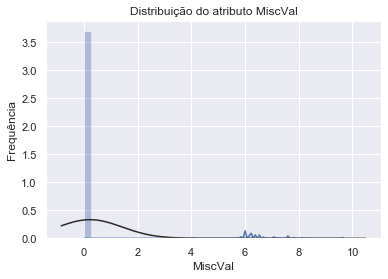

In [40]:
sns.distplot(x_train_numerico['MiscVal'] , fit=norm);

plt.ylabel('Frequência')
plt.title('Distribuição do atributo MiscVal')

##### Normalização dos dados numéricos

In [41]:
x_train_numerico = pd.DataFrame(min_max_scaler.fit_transform(x_train_numerico), columns=x_train_numerico.columns)

In [42]:
x_train_categorico.index = x_train_numerico.index
y_train_sales_price.index = x_train_numerico.index

##### One-hot encode dos dados categóricos

In [43]:
print("Formato dos dados categóricos antes da transformação: {}".format(x_train_categorico.shape))
x_train_categorico = pd.get_dummies(x_train_categorico)
print("Formato dos dados categóricos após a transformação:   {}".format(x_train_categorico.shape))

Formato dos dados categóricos antes da transformação: (1411, 43)
Formato dos dados categóricos após a transformação:   (1411, 261)


##### Geração do DataFrame completo, contendo os dados categóricos e numéricos tratados, junto com o valor de venda

In [44]:
x_train_tratado = x_train_categorico.join(x_train_numerico)

train_tratado = x_train_tratado.join(y_train_sales_price)

train_tratado.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NA,Alley_Pave,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0,0,0,1,0,0,1,0,1,0,...,0.000000,0.654449,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,208500
1,0,0,0,1,0,0,1,0,1,0,...,0.843935,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,181500
2,0,0,0,1,0,0,1,0,1,0,...,0.000000,0.596422,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,223500
3,0,0,0,1,0,0,1,0,1,0,...,0.000000,0.568247,0.966797,0.0,0.0,0.0,0.0,0.090909,0.00,140000
4,0,0,0,1,0,0,1,0,1,0,...,0.779126,0.704481,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,250000


Vamos executar as regressões novamente para ver o impacto do tratamentos realizado.

In [45]:
X_train, X_test, Y_train, Y_test = prepara_X_Y_train(x_train_tratado, y_train_sales_price)
executa_regressoes()

Resultados para o modelo Regressão Linear:
---------------------------------------------------
R2 Score:     -0.007
RMSLE:         3.196

Resultados para o modelo Ridge:
---------------------------------------------------
R2 Score:      0.890
RMSLE:         0.138

Resultados para o modelo Lasso:
---------------------------------------------------
R2 Score:      0.882
RMSLE:         0.158

Resultados para o modelo ElasticNet:
---------------------------------------------------
R2 Score:      0.352
RMSLE:         0.188



/Users/robsonrung/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23519779541.559174, tolerance: 476956804.7220508
  positive)


Resultados para o modelo DecisionTreeClassifier:
---------------------------------------------------
R2 Score:      0.536
RMSLE:         0.252

[17:54:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Resultados para o modelo XGBoost:
---------------------------------------------------
R2 Score:      0.903
RMSLE:         0.118



In [46]:
model = cria_rede_neural(298, [298, 32, 16])
treina_rede_neural(model, X_train, Y_train, X_test, Y_test, epochs=100, mostra_execucao=False)

424/424 [==============================] - 0s 478us/step


In [47]:
executa_rede_neural(model, X_test, Y_train)

Resultados para o modelo Rede Neural:
---------------------------------------------------
R2 Score:    -37.688
RMSLE:         0.327



,previsto
0,129859.835938
1,161631.937500
2,152575.875000
3,156162.968750
4,139620.187500
5,129974.500000
6,135932.250000
7,152880.125000
8,164735.546875
9,146518.359375


Mais uma vez, continuamos com evolução nos resultados.

##### PCA

In [48]:
pca = PCA(n_components=298)
pca.fit(x_train_tratado)

PCA(copy=True, iterated_power='auto', n_components=298, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

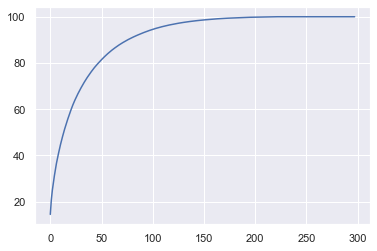

In [49]:
variancia_acumulada = pd.Series(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
sns.lineplot(data=variancia_acumulada)

Percebe-se que com cerca da metade dos compomentes já é possível explicar quase que a totalidade da variância observada nos dados. 

Faremos, então, um teste de regressão com 150 componentes.

In [94]:
pca = PCA(n_components=150)
pca.fit(x_train_tratado)
x_pca = pd.DataFrame(pca.transform(x_train_tratado))
x_pca.index = x_train_tratado.index

X_train, X_test, Y_train, Y_test = prepara_X_Y_train(x_pca, y_train_sales_price)
executa_regressoes()

Resultados para o modelo Regressão Linear:
---------------------------------------------------
R2 Score:      0.886
RMSLE:         0.136

Resultados para o modelo Ridge:
---------------------------------------------------
R2 Score:      0.881
RMSLE:         0.130

Resultados para o modelo Lasso:
---------------------------------------------------
R2 Score:      0.886
RMSLE:         0.135

Resultados para o modelo ElasticNet:
---------------------------------------------------
R2 Score:    -78.073
RMSLE:         0.342

Resultados para o modelo DecisionTreeClassifier:
---------------------------------------------------
R2 Score:     -0.036
RMSLE:         0.364

[18:44:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Resultados para o modelo XGBoost:
---------------------------------------------------
R2 Score:      0.737
RMSLE:         0.166



In [103]:
model = cria_rede_neural(learn_rate=0.01) 
# , [150, 32, 16, 32, 16])
treina_rede_neural(model, X_train, Y_train, X_test, Y_test, epochs=200, batch_size=32, mostra_execucao=True)

2019-08-05 18:59:33.365823
Train on 987 samples, validate on 424 samples
Epoch 1/200
987/987 [==============================] - 3s 3ms/step - loss: 108.1593 - val_loss: 28.3283
Epoch 2/200
987/987 [==============================] - 0s 111us/step - loss: 10.9793 - val_loss: 3.0158
Epoch 3/200
987/987 [==============================] - 0s 109us/step - loss: 1.3084 - val_loss: 0.3586
Epoch 4/200
987/987 [==============================] - 0s 109us/step - loss: 0.1963 - val_loss: 0.1362
Epoch 5/200
987/987 [==============================] - 0s 104us/step - loss: 0.1453 - val_loss: 0.1359
Epoch 6/200
987/987 [==============================] - 0s 107us/step - loss: 0.1447 - val_loss: 0.1358
Epoch 7/200
987/987 [==============================] - 0s 103us/step - loss: 0.1446 - val_loss: 0.1359
Epoch 8/200
987/987 [==============================] - 0s 107us/step - loss: 0.1447 - val_loss: 0.1357
Epoch 9/200
987/987 [==============================] - 0s 110us/step - loss: 0.1448 - val_loss: 0.135

987/987 [==============================] - 0s 118us/step - loss: 0.0880 - val_loss: 0.0824
Epoch 80/200
987/987 [==============================] - 0s 112us/step - loss: 0.0837 - val_loss: 0.0784
Epoch 81/200
987/987 [==============================] - 0s 304us/step - loss: 0.0804 - val_loss: 0.0748
Epoch 82/200
987/987 [==============================] - 0s 107us/step - loss: 0.0766 - val_loss: 0.0704
Epoch 83/200
987/987 [==============================] - 0s 110us/step - loss: 0.0708 - val_loss: 0.0657
Epoch 84/200
987/987 [==============================] - 0s 111us/step - loss: 0.0661 - val_loss: 0.0621
Epoch 85/200
987/987 [==============================] - 0s 106us/step - loss: 0.0614 - val_loss: 0.0567
Epoch 86/200
987/987 [==============================] - 0s 108us/step - loss: 0.0559 - val_loss: 0.0520
Epoch 87/200
987/987 [==============================] - 0s 110us/step - loss: 0.0510 - val_loss: 0.0471
Epoch 88/200
987/987 [==============================] - 0s 107us/step - loss:

987/987 [==============================] - 0s 115us/step - loss: 0.0127 - val_loss: 0.0170
Epoch 158/200
987/987 [==============================] - 0s 115us/step - loss: 0.0121 - val_loss: 0.0170
Epoch 159/200
987/987 [==============================] - 0s 112us/step - loss: 0.0121 - val_loss: 0.0169
Epoch 160/200
987/987 [==============================] - 0s 128us/step - loss: 0.0123 - val_loss: 0.0179
Epoch 161/200
987/987 [==============================] - 0s 114us/step - loss: 0.0127 - val_loss: 0.0166
Epoch 162/200
987/987 [==============================] - 0s 113us/step - loss: 0.0122 - val_loss: 0.0173
Epoch 163/200
987/987 [==============================] - 0s 112us/step - loss: 0.0117 - val_loss: 0.0170
Epoch 164/200
987/987 [==============================] - 0s 113us/step - loss: 0.0122 - val_loss: 0.0168
Epoch 165/200
987/987 [==============================] - 0s 112us/step - loss: 0.0122 - val_loss: 0.0170
Epoch 166/200
987/987 [==============================] - 0s 305us/ste

In [104]:
executa_rede_neural(model, X_test, Y_train)

Resultados para o modelo Rede Neural:
---------------------------------------------------
R2 Score:      0.848
RMSLE:         0.127



Agora tivemos um resultado variado para os diversos modelos, ou seja, alguns tiveram melhorias em seus índices, mas outros pioraram. 

Especificamente em relação aos dois que vinham conseguindo melhores resultados, XGBoost e Rede Neural, o primeiro teve piora, e o segundo, melhora.

Vamos tentar otimizar os parâmetros do XGBoost, usando GridSearch.

Começamos executando otimizações em parâmetros individuais, e chegamos aos valores abaixo:

- max_depth=3
- colsample_bytree=0.3
- min_child_weight=0.3
- gamma=0
- learning_rate=0.1
- n_estimators=300
- reg_alpha=1e-5
- reg_lambda=0.4
- subsample=0.5

Agora vamos variar cada parâmetros para mais e para menos e vamos usar GridSearch para encontrar a melhor combinação.

In [113]:
# Vamos recarregar os dados de quando o XGBoost teve a melhor performance
X_train, X_test, Y_train, Y_test = prepara_X_Y_train(x_train_tratado, y_train_sales_price)

# parâmetros a serem usados
parameters_for_testing = {
    'max_depth':[3,4],
    'colsample_bytree':[0.2,0.3,0.4],
    'min_child_weight':[0.2,0.3,0.4],
    'gamma':[0,0.01],
    'learning_rate':[0.08, 0.1, 0.12],
    'n_estimators':[200, 300, 400],
    'reg_alpha':[1e-4, 1e-5, 1e-6],
    'reg_lambda':[0.35,0.4,0.45],
    'subsample':[0.4,0.5,0.6]  
}

xgb_model = xgboost.XGBRegressor()

gsearch = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=-1,iid=False, verbose=10,scoring='neg_mean_squared_error')

gsearch.fit(X_train,Y_train)

Fitting 3 folds for each of 8748 candidates, totalling 26244 fits


/Users/robsonrung/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 1

[Parallel(n_jobs=-1)]: Done 8569 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 8700 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 8833 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done 8966 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done 9101 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done 9236 tasks      | elapsed: 33.2min
[Parallel(n_jobs=-1)]: Done 9373 tasks      | elapsed: 33.6min
[Parallel(n_jobs=-1)]: Done 9510 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done 9649 tasks      | elapsed: 34.7min
[Parallel(n_jobs=-1)]: Done 9788 tasks      | elapsed: 35.3min
[Parallel(n_jobs=-1)]: Done 9929 tasks      | elapsed: 35.9min
[Parallel(n_jobs=-1)]: Done 10070 tasks      | elapsed: 36.5min
[Parallel(n_jobs=-1)]: Done 10213 tasks      | elapsed: 37.2min
[Parallel(n_jobs=-1)]: Done 10356 tasks      | elapsed: 37.6min
[Parallel(n_jobs=-1)]: Done 10501 tasks      | elapsed: 38.2min
[Parallel(n_jobs=-1)]: Done 10646 tasks      | elap

[21:17:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_sta...
             param_grid={'colsample_bytree': [0.2, 0.3, 0.4],
                         'gamma': [0, 0.01], 'learning_rate': [0.08, 0.1, 0.12],
                         'max_depth': [3, 4],
                         'min_child_weight': [0.2, 0.3, 0.4],
                         'n_estimators': [200, 300, 400],
                         'reg_alpha': [0.0001, 1e-05, 

In [114]:
gsearch.best_params_

{'colsample_bytree': 0.2,
 'gamma': 0,
 'learning_rate': 0.08,
 'max_depth': 3,
 'min_child_weight': 0.2,
 'n_estimators': 400,
 'reg_alpha': 0.0001,
 'reg_lambda': 0.35,
 'subsample': 0.6}

Após 26.244 execuções com todas as possíveis combinações de parâmetros, o melhor resultado foi obtido com a seguinte configuração:

````
gsearch.best_params_

{'colsample_bytree': 0.2,
 'gamma': 0,
 'learning_rate': 0.08,
 'max_depth': 3,
 'min_child_weight': 0.2,
 'n_estimators': 400,
 'reg_alpha': 0.0001,
 'reg_lambda': 0.35,
 'subsample': 0.6}
````

Vamos executar a regressão para ver o quanto conseguimos melhorar os resultados.

In [115]:
regressao(xgboost.XGBRegressor(max_depth=3, colsample_bytree=0.2, min_child_weight=0.2, gamma=0, 
                                 learning_rate=0.08, n_estimators=400, reg_alpha = 0.0001, reg_lambda=0.35,
                                 subsample=0.6), X_train, Y_train.values, X_test, Y_test, titulo="XGBoost")

[21:58:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Resultados para o modelo XGBoost:
---------------------------------------------------
R2 Score:      0.915
RMSLE:         0.113



Ótimo, foi o nosso melhor resultado até o momento.

Agora vamos tentar otimizar a rede neural, também com o auxílio do algoritmo de GridSearch e o *Wrapper* de *Keras* para *Scikit-Learn*, chamado ````KerasClassifier````.

In [127]:
X_train, X_test, Y_train, Y_test = prepara_X_Y_train(x_pca, y_train_sales_price)

In [ ]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=cria_rede_neural, epochs=100, batch_size=30, verbose=1)

# define the grid search parameters
batch_size = [20, 30, 40]
epochs = [100,150,200]
learn_rate = [0.005, 0.01, 0.015]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
camadas=[1,2,3,4,5]
neuronios=[8,16,32]
param_grid = dict(batch_size=batch_size,optimizer=optimizer,init_mode=init_mode,
                  activation=activation,camadas=camadas,neuronios=neuronios,
                  epochs=epochs,learn_rate=learn_rate)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,scoring='r2')
grid_result = grid.fit(X=X_train, y=Y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/robsonrung/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [130]:
model.reset_states
model = cria_rede_neural(activation='linear', camadas=1,init_mode='uniform', neuronios=16,optimizer='SGD') 
# , [150, 32, 16, 32, 16])
treina_rede_neural(model, X_train, Y_train, X_test, Y_test, epochs=300, mostra_execucao=True)
executa_rede_neural(model, X_test, Y_train)

2019-08-05 22:32:41.125758
Train on 987 samples, validate on 424 samples
Epoch 1/300
987/987 [==============================] - 3s 3ms/step - loss: 137.2767 - val_loss: 130.5150
Epoch 2/300
987/987 [==============================] - 0s 91us/step - loss: 120.8737 - val_loss: 108.8141
Epoch 3/300
987/987 [==============================] - 0s 94us/step - loss: 97.7716 - val_loss: 88.2053
Epoch 4/300
987/987 [==============================] - 0s 91us/step - loss: 81.6764 - val_loss: 76.1087
Epoch 5/300
987/987 [==============================] - 0s 284us/step - loss: 71.9217 - val_loss: 68.3048
Epoch 6/300
987/987 [==============================] - 0s 89us/step - loss: 65.3120 - val_loss: 62.7309
Epoch 7/300
987/987 [==============================] - 0s 89us/step - loss: 60.4315 - val_loss: 58.4707
Epoch 8/300
987/987 [==============================] - 0s 105us/step - loss: 56.6158 - val_loss: 55.0615
Epoch 9/300
987/987 [==============================] - 0s 96us/step - loss: 53.5128 - val_

987/987 [==============================] - 0s 98us/step - loss: 18.5223 - val_loss: 18.5344
Epoch 79/300
987/987 [==============================] - 0s 98us/step - loss: 18.3901 - val_loss: 18.4032
Epoch 80/300
987/987 [==============================] - 0s 87us/step - loss: 18.2603 - val_loss: 18.2742
Epoch 81/300
987/987 [==============================] - 0s 99us/step - loss: 18.1326 - val_loss: 18.1473
Epoch 82/300
987/987 [==============================] - 0s 96us/step - loss: 18.0071 - val_loss: 18.0226
Epoch 83/300
987/987 [==============================] - 0s 283us/step - loss: 17.8837 - val_loss: 17.8999
Epoch 84/300
987/987 [==============================] - 0s 92us/step - loss: 17.7623 - val_loss: 17.7793
Epoch 85/300
987/987 [==============================] - 0s 93us/step - loss: 17.6429 - val_loss: 17.6606
Epoch 86/300
987/987 [==============================] - 0s 90us/step - loss: 17.5254 - val_loss: 17.5437
Epoch 87/300
987/987 [==============================] - 0s 94us/ste

987/987 [==============================] - 0s 97us/step - loss: 12.2460 - val_loss: 12.2836
Epoch 156/300
987/987 [==============================] - 0s 95us/step - loss: 12.1950 - val_loss: 12.2326
Epoch 157/300
987/987 [==============================] - 0s 89us/step - loss: 12.1444 - val_loss: 12.1821
Epoch 158/300
987/987 [==============================] - 0s 98us/step - loss: 12.0943 - val_loss: 12.1321
Epoch 159/300
987/987 [==============================] - 0s 91us/step - loss: 12.0447 - val_loss: 12.0825
Epoch 160/300
987/987 [==============================] - 0s 89us/step - loss: 11.9955 - val_loss: 12.0334
Epoch 161/300
987/987 [==============================] - 0s 88us/step - loss: 11.9467 - val_loss: 11.9847
Epoch 162/300
987/987 [==============================] - 0s 95us/step - loss: 11.8983 - val_loss: 11.9364
Epoch 163/300
987/987 [==============================] - 0s 94us/step - loss: 11.8504 - val_loss: 11.8885
Epoch 164/300
987/987 [==============================] - 0s 

987/987 [==============================] - 0s 91us/step - loss: 9.3041 - val_loss: 9.3438
Epoch 233/300
987/987 [==============================] - 0s 92us/step - loss: 9.2755 - val_loss: 9.3151
Epoch 234/300
987/987 [==============================] - 0s 94us/step - loss: 9.2470 - val_loss: 9.2867
Epoch 235/300
987/987 [==============================] - 0s 92us/step - loss: 9.2188 - val_loss: 9.2584
Epoch 236/300
987/987 [==============================] - 0s 89us/step - loss: 9.1907 - val_loss: 9.2303
Epoch 237/300
987/987 [==============================] - 0s 95us/step - loss: 9.1628 - val_loss: 9.2024
Epoch 238/300
987/987 [==============================] - 0s 90us/step - loss: 9.1350 - val_loss: 9.1746
Epoch 239/300
987/987 [==============================] - 0s 95us/step - loss: 9.1074 - val_loss: 9.1471
Epoch 240/300
987/987 [==============================] - 0s 89us/step - loss: 9.0800 - val_loss: 9.1197
Epoch 241/300
987/987 [==============================] - 0s 95us/step - loss: 

## IV - Resultados

### Avaliação e validação do modelo

### Justificativa

## V - Conclusão

### Visualização

### Reflexões

### Melhorias

#### Referências

[A] Almeida, Pedro Henrique Ramos. Fatores determinantes para a formação de preço no mercado imobiliário de Brasília. Brasília. 2001. Universidade de Brasília. Disponível em [http://bdm.unb.br/bitstream/10483/2122/1/2011_PedroHenriqueRamosdeAlmeida.pdf](http://bdm.unb.br/bitstream/10483/2122/1/2011_PedroHenriqueRamosdeAlmeida.pdf)

[B] Belfiore, Patrícia Prado. Fávero, Luiz Paulo Lopes. Lima, Gerlando A. S. Franco. Modelos de precificação hedônica de imóveis residenciais na região metropolitana de São Paulo: uma abordagem sob as perspectivas da demanda e da oferta. São Paulo Jan./Mar. 2008. Estud. Econ. vol.38. Disponível em [http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0101-41612008000100004](http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0101-41612008000100004)

[C] Kaggle. House Prices: Advanced Regression Techniques. Disponível em [https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)